In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

#print_config()

from ResSwinUnet import swinUnet_t_3D_Residual

2024-11-26 15:04:13.488377: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 15:04:13.531851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total number of trainable parameters: 48115676


In [2]:
root_dir = "./scratch/ResSWINUnet_Synapse_Best_Model"

In [3]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

/home/hice1/bmallya3/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [4]:
data_dir = "./scratch/data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


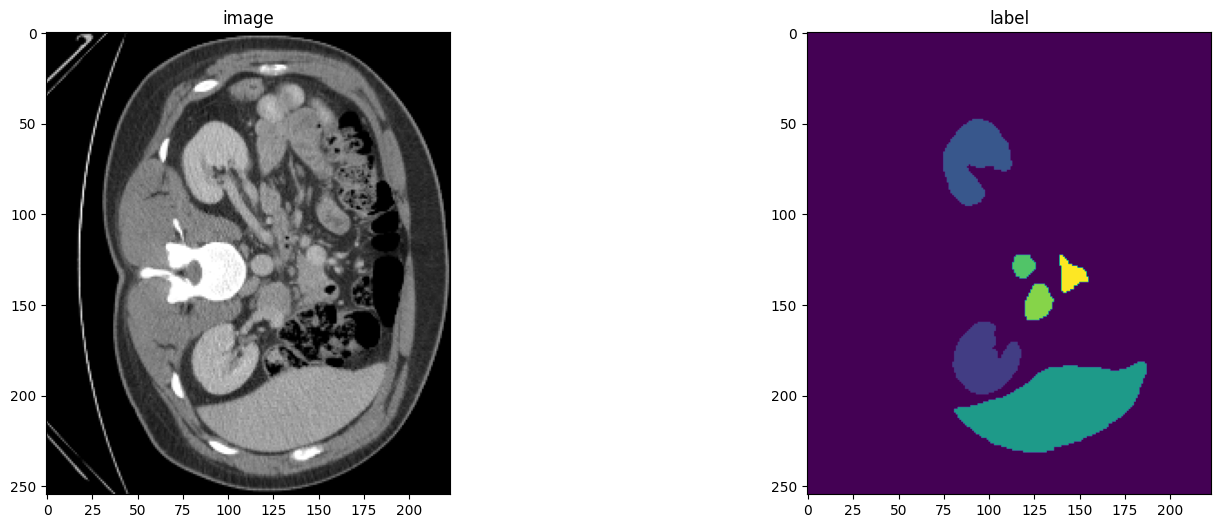

In [32]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 180,
    "img0037.nii.gz": 180,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [6]:
model = swinUnet_t_3D_Residual(in_channel=1, num_classes=14).to("cuda")

In [7]:

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of trainable parameters: {total_params}")



Total number of trainable parameters: 48114503


In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

/scratch/985307/ipykernel_1249796/2830719074.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        #print("aggregrate dice = ",dice_metric.aggregate())
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})"
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

Training (X / X Steps) (loss=X.X):   0%|          | 0/24 [00:00<?, ?it/s]/scratch/985307/ipykernel_1249796/3874293951.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validate (X / X Steps) (dice=X.X):   0%|          | 0/6 [00:00<?, ?it/s]/scratch/985307/ipykernel_1249796/3874293951.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Training (500 / 30000 Steps) (loss=1.94271):  88%|████████▊ | 21/24 [00:15<00:06,  2.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.07062418013811111 Current Avg. Dice: 0.07062418013811111


Training (1000 / 30000 Steps) (loss=1.67981):  71%|███████   | 17/24 [00:13<00:13,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.07062418013811111 Current Avg. Dice: 0.07062418013811111


Training (1500 / 30000 Steps) (loss=1.48586):  54%|█████▍    | 13/24 [00:11<00:21,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.07062418013811111 Current Avg. Dice: 0.07062418013811111


Training (2000 / 30000 Steps) (loss=1.18948):  38%|███▊      | 9/24 [00:09<00:31,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12027302384376526 Current Avg. Dice: 0.12027302384376526


Training (2500 / 30000 Steps) (loss=1.21763):  21%|██        | 5/24 [00:07<00:44,  2.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12595780193805695 Current Avg. Dice: 0.12595780193805695


Training (3000 / 30000 Steps) (loss=1.21577):   4%|▍         | 1/24 [00:05<02:11,  5.71s/it]

Model Was Saved ! Current Best Avg. Dice: 0.14016924798488617 Current Avg. Dice: 0.14016924798488617


Training (3500 / 30000 Steps) (loss=1.16310):  88%|████████▊ | 21/24 [00:15<00:06,  2.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.17569975554943085 Current Avg. Dice: 0.17569975554943085


Training (4000 / 30000 Steps) (loss=1.17303):  71%|███████   | 17/24 [00:13<00:14,  2.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.21166829764842987 Current Avg. Dice: 0.21166829764842987


Training (4500 / 30000 Steps) (loss=1.33369):  54%|█████▍    | 13/24 [00:11<00:22,  2.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.28550854325294495 Current Avg. Dice: 0.28550854325294495


Training (5000 / 30000 Steps) (loss=0.89471):  38%|███▊      | 9/24 [00:09<00:31,  2.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.42125585675239563 Current Avg. Dice: 0.42125585675239563


Training (5500 / 30000 Steps) (loss=0.79002):  21%|██        | 5/24 [00:07<00:44,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5762208104133606 Current Avg. Dice: 0.5762208104133606


Training (6000 / 30000 Steps) (loss=0.72462):   4%|▍         | 1/24 [00:05<02:12,  5.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.616990864276886 Current Avg. Dice: 0.616990864276886


Training (6500 / 30000 Steps) (loss=0.68899):  88%|████████▊ | 21/24 [00:15<00:06,  2.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6582023501396179 Current Avg. Dice: 0.6582023501396179


Training (7000 / 30000 Steps) (loss=0.47596):  71%|███████   | 17/24 [00:13<00:14,  2.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6884757876396179 Current Avg. Dice: 0.6884757876396179


Training (7500 / 30000 Steps) (loss=0.57302):  54%|█████▍    | 13/24 [00:11<00:22,  2.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.710639476776123 Current Avg. Dice: 0.710639476776123


Training (8000 / 30000 Steps) (loss=0.64224):  38%|███▊      | 9/24 [00:09<00:31,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.769172191619873 Current Avg. Dice: 0.769172191619873


Training (8500 / 30000 Steps) (loss=0.59809):  21%|██        | 5/24 [00:07<00:44,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.78008633852005 Current Avg. Dice: 0.78008633852005


Training (9000 / 30000 Steps) (loss=0.76182):   4%|▍         | 1/24 [00:05<02:11,  5.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7846658825874329 Current Avg. Dice: 0.7846658825874329


Training (9500 / 30000 Steps) (loss=0.43863):  88%|████████▊ | 21/24 [00:15<00:06,  2.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7935300469398499 Current Avg. Dice: 0.7935300469398499


Training (10000 / 30000 Steps) (loss=0.50394):  71%|███████   | 17/24 [00:13<00:14,  2.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8028838038444519 Current Avg. Dice: 0.8028838038444519


Training (10500 / 30000 Steps) (loss=0.44146):  54%|█████▍    | 13/24 [00:11<00:22,  2.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8045185208320618 Current Avg. Dice: 0.8045185208320618


Training (11000 / 30000 Steps) (loss=0.44373):  38%|███▊      | 9/24 [00:09<00:30,  2.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8045185208320618 Current Avg. Dice: 0.7811970114707947


Training (11500 / 30000 Steps) (loss=0.52065):  21%|██        | 5/24 [00:07<00:43,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8045185208320618 Current Avg. Dice: 0.8037574887275696


Training (12000 / 30000 Steps) (loss=0.31604):   4%|▍         | 1/24 [00:05<02:10,  5.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8094008564949036 Current Avg. Dice: 0.8094008564949036


Training (12500 / 30000 Steps) (loss=0.47461):  88%|████████▊ | 21/24 [00:15<00:05,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8094008564949036 Current Avg. Dice: 0.8044182658195496


Training (13000 / 30000 Steps) (loss=0.38192):  71%|███████   | 17/24 [00:13<00:14,  2.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8133808970451355 Current Avg. Dice: 0.8133808970451355


Training (13500 / 30000 Steps) (loss=0.43695):  54%|█████▍    | 13/24 [00:11<00:21,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8133808970451355 Current Avg. Dice: 0.805025577545166


Training (14000 / 30000 Steps) (loss=0.61067):  38%|███▊      | 9/24 [00:09<00:30,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8133808970451355 Current Avg. Dice: 0.8096146583557129


Training (14500 / 30000 Steps) (loss=0.51909):  21%|██        | 5/24 [00:07<00:43,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8133808970451355 Current Avg. Dice: 0.792151927947998


Training (15000 / 30000 Steps) (loss=0.42804):   4%|▍         | 1/24 [00:05<02:12,  5.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8169786334037781 Current Avg. Dice: 0.8169786334037781


Training (15500 / 30000 Steps) (loss=0.43431):  88%|████████▊ | 21/24 [00:15<00:06,  2.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8197870254516602 Current Avg. Dice: 0.8197870254516602


Training (16000 / 30000 Steps) (loss=0.50960):  71%|███████   | 17/24 [00:13<00:13,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8197870254516602 Current Avg. Dice: 0.8042650818824768


Training (16500 / 30000 Steps) (loss=0.34802):  54%|█████▍    | 13/24 [00:11<00:22,  2.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8223457932472229 Current Avg. Dice: 0.8223457932472229


Training (17000 / 30000 Steps) (loss=0.40588):  38%|███▊      | 9/24 [00:09<00:30,  2.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8223457932472229 Current Avg. Dice: 0.8185019493103027


Training (17500 / 30000 Steps) (loss=0.39198):  21%|██        | 5/24 [00:07<00:43,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8223457932472229 Current Avg. Dice: 0.8201808929443359


Training (18000 / 30000 Steps) (loss=0.35806):   4%|▍         | 1/24 [00:05<02:06,  5.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8223457932472229 Current Avg. Dice: 0.8207364678382874


Training (18500 / 30000 Steps) (loss=0.31961):  88%|████████▊ | 21/24 [00:15<00:05,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8223457932472229 Current Avg. Dice: 0.8094000816345215


Training (18690 / 30000 Steps) (loss=0.42704):  75%|███████▌  | 18/24 [00:09<00:02,  2.08it/s]

In [13]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")


train completed, best_metric: 0.8265 at iteration: 29000


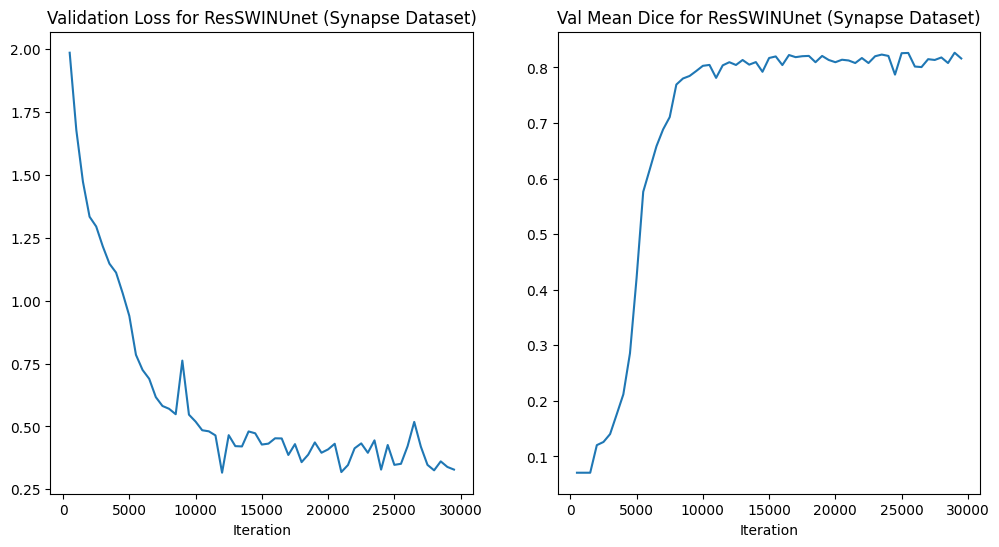

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Validation Loss for ResSWINUnet (Synapse Dataset)")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice for ResSWINUnet (Synapse Dataset)")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
import pandas as pd



validation_data ={
    'valid_losses':epoch_loss_values,
    'mean_dice':metric_values
} 

valid_df = pd.DataFrame(validation_data)

valid_csv_file_path = root_dir

csv_file_name = f'metrics_resswinunet_synapse.csv'

valid_df.to_csv(os.path.join(valid_csv_file_path,csv_file_name), index=False)

/scratch/985307/ipykernel_1249796/635271530.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pt

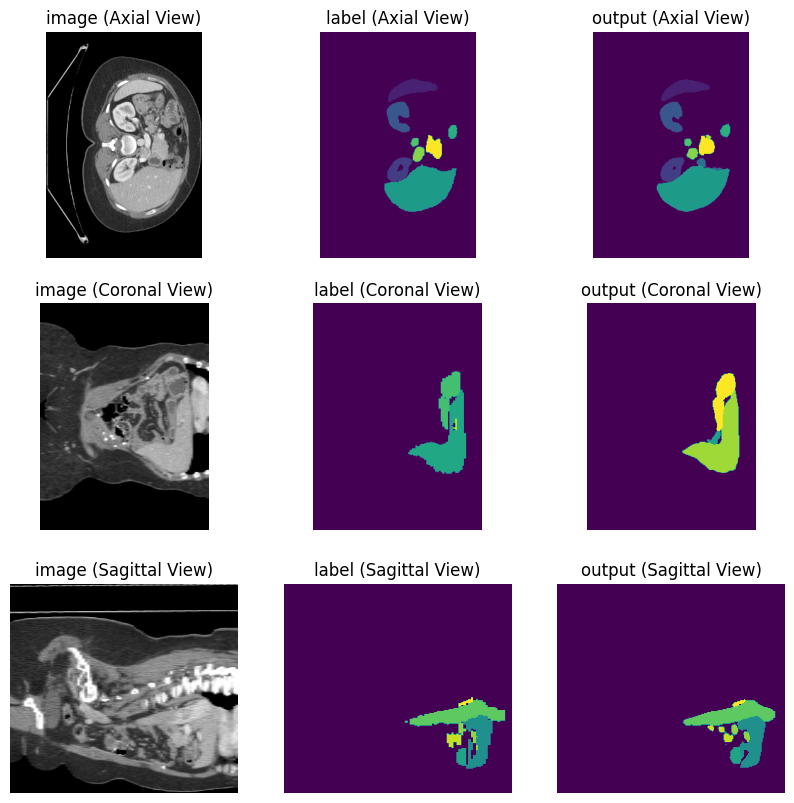

In [23]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
for case_num in range(0,1):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
        plt.figure("check", (10, 10))
        plt.subplot(3, 3, 1)
        plt.title("image (Axial View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 2)
        plt.title("label (Axial View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.axis('off')
        plt.subplot(3, 3, 3)
        plt.title("output (Axial View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.axis('off')
        
        plt.subplot(3, 3, 4)
        plt.title("image (Coronal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, slice_map[img_name], :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 5)
        plt.title("label (Coronal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, slice_map[img_name], :])
        plt.axis('off')
        plt.subplot(3, 3, 6)
        plt.title("output (Coronal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, slice_map[img_name], :])
        plt.axis('off')
        
        plt.subplot(3, 3, 7)
        plt.title("image (Sagittal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, slice_map[img_name], :, :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 8)
        plt.title("label (Sagittal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.subplot(3, 3, 9)
        plt.title("output (Sagittal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.show()

/scratch/985307/ipykernel_1249796/2862939785.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.p

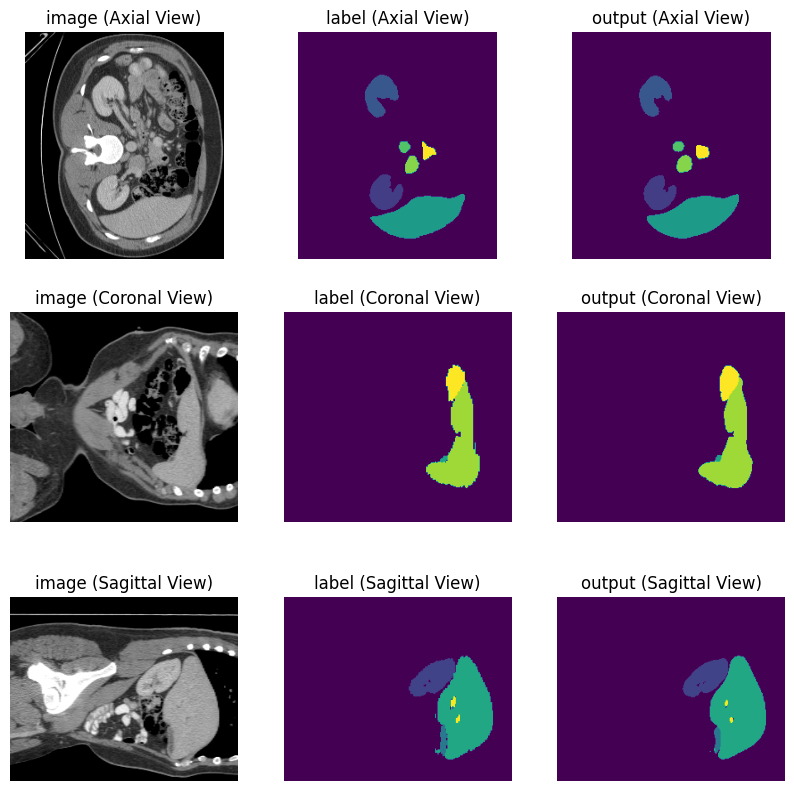

In [28]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
for case_num in range(1,2):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
        plt.figure("check", (10, 10))
        plt.subplot(3, 3, 1)
        plt.title("image (Axial View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 2)
        plt.title("label (Axial View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.axis('off')
        plt.subplot(3, 3, 3)
        plt.title("output (Axial View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.axis('off')
        
        plt.subplot(3, 3, 4)
        plt.title("image (Coronal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, slice_map[img_name], :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 5)
        plt.title("label (Coronal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, slice_map[img_name], :])
        plt.axis('off')
        plt.subplot(3, 3, 6)
        plt.title("output (Coronal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, slice_map[img_name], :])
        plt.axis('off')
        
        plt.subplot(3, 3, 7)
        plt.title("image (Sagittal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, slice_map[img_name], :, :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 8)
        plt.title("label (Sagittal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.subplot(3, 3, 9)
        plt.title("output (Sagittal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.show()

/scratch/985307/ipykernel_1249796/1341330300.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.p

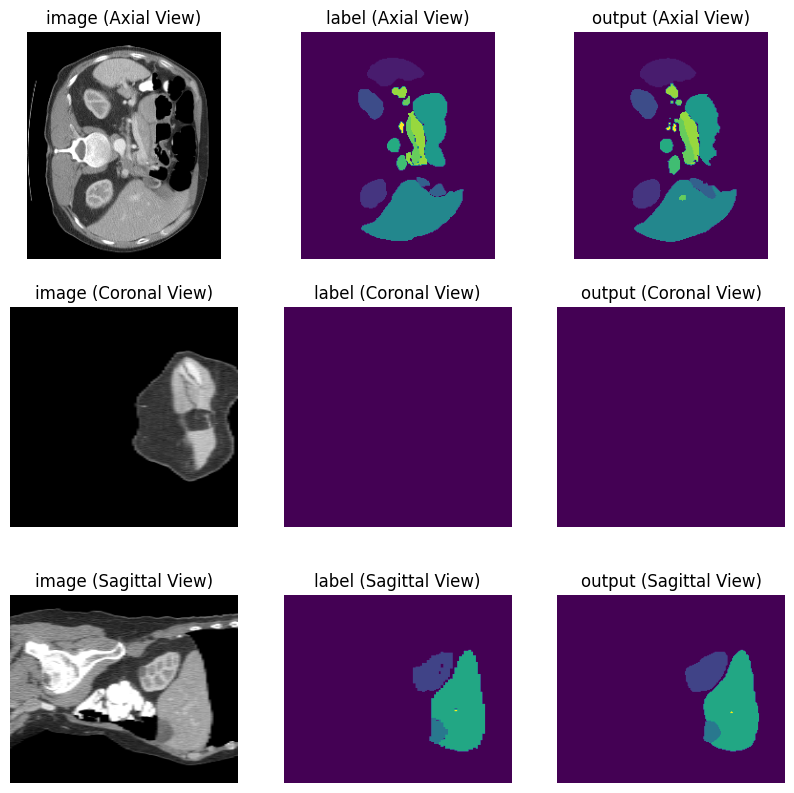

In [33]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
for case_num in range(2,3):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
        plt.figure("check", (10, 10))
        plt.subplot(3, 3, 1)
        plt.title("image (Axial View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 2)
        plt.title("label (Axial View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.axis('off')
        plt.subplot(3, 3, 3)
        plt.title("output (Axial View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.axis('off')
        
        plt.subplot(3, 3, 4)
        plt.title("image (Coronal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, slice_map[img_name], :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 5)
        plt.title("label (Coronal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, slice_map[img_name], :])
        plt.axis('off')
        plt.subplot(3, 3, 6)
        plt.title("output (Coronal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, slice_map[img_name], :])
        plt.axis('off')
        
        plt.subplot(3, 3, 7)
        plt.title("image (Sagittal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, slice_map[img_name], :, :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 8)
        plt.title("label (Sagittal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.subplot(3, 3, 9)
        plt.title("output (Sagittal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.show()

/scratch/985307/ipykernel_1249796/3901631144.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.p

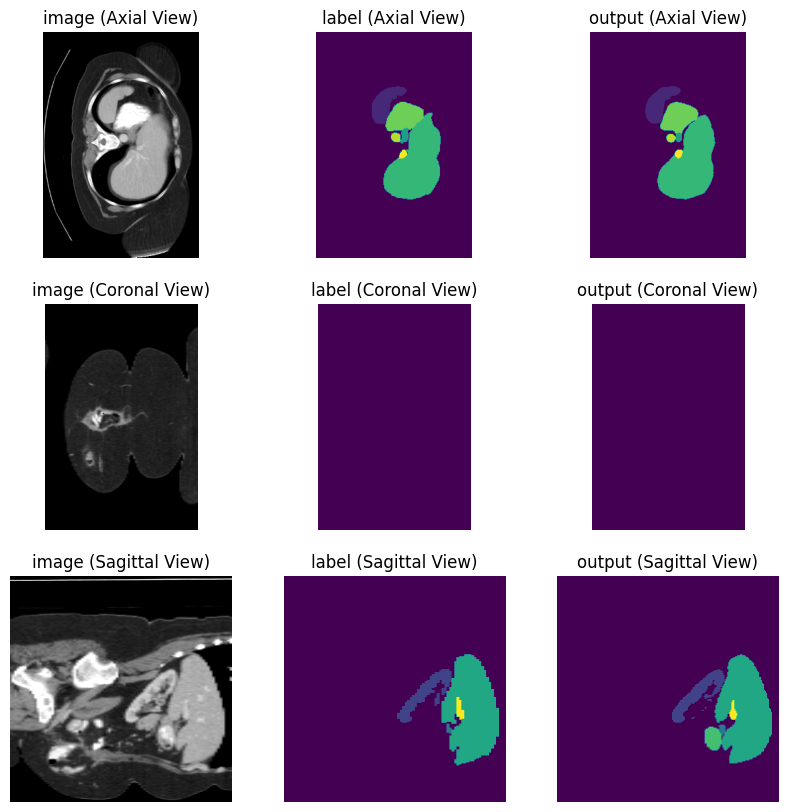

In [35]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
for case_num in range(4,5):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
        plt.figure("check", (10, 10))
        plt.subplot(3, 3, 1)
        plt.title("image (Axial View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 2)
        plt.title("label (Axial View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.axis('off')
        plt.subplot(3, 3, 3)
        plt.title("output (Axial View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.axis('off')
        
        plt.subplot(3, 3, 4)
        plt.title("image (Coronal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, slice_map[img_name], :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 5)
        plt.title("label (Coronal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, slice_map[img_name], :])
        plt.axis('off')
        plt.subplot(3, 3, 6)
        plt.title("output (Coronal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, slice_map[img_name], :])
        plt.axis('off')
        
        plt.subplot(3, 3, 7)
        plt.title("image (Sagittal View)")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, slice_map[img_name], :, :], cmap="gray")
        plt.axis('off')
        plt.subplot(3, 3, 8)
        plt.title("label (Sagittal View)")
        plt.imshow(val_labels.cpu().numpy()[0, 0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.subplot(3, 3, 9)
        plt.title("output (Sagittal View)")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, slice_map[img_name], :, :])
        plt.axis('off')
        plt.show()

/scratch/985307/ipykernel_1249796/522763016.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pt

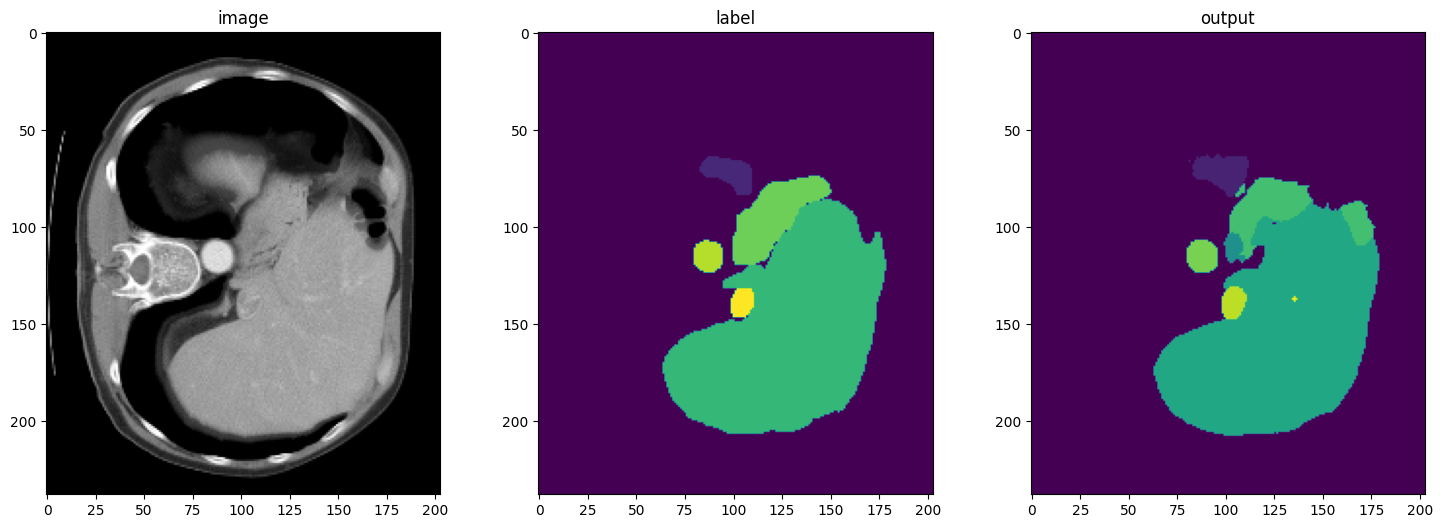

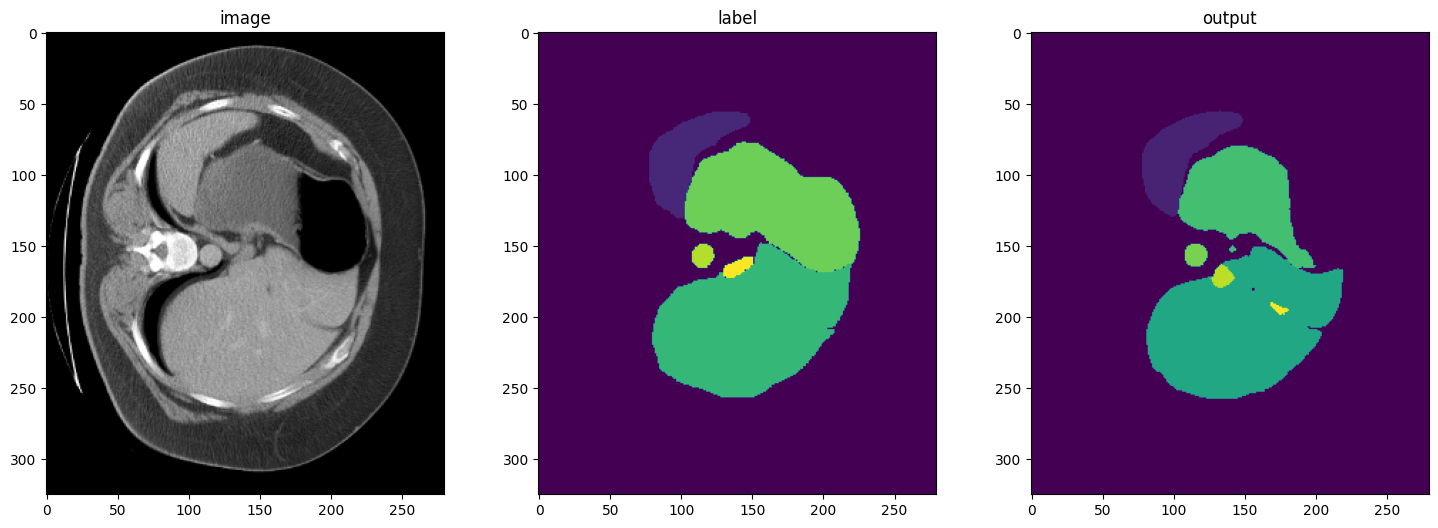

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
for case_num in range(2,4):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.show()

/scratch/985307/ipykernel_1249796/4254228025.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.p

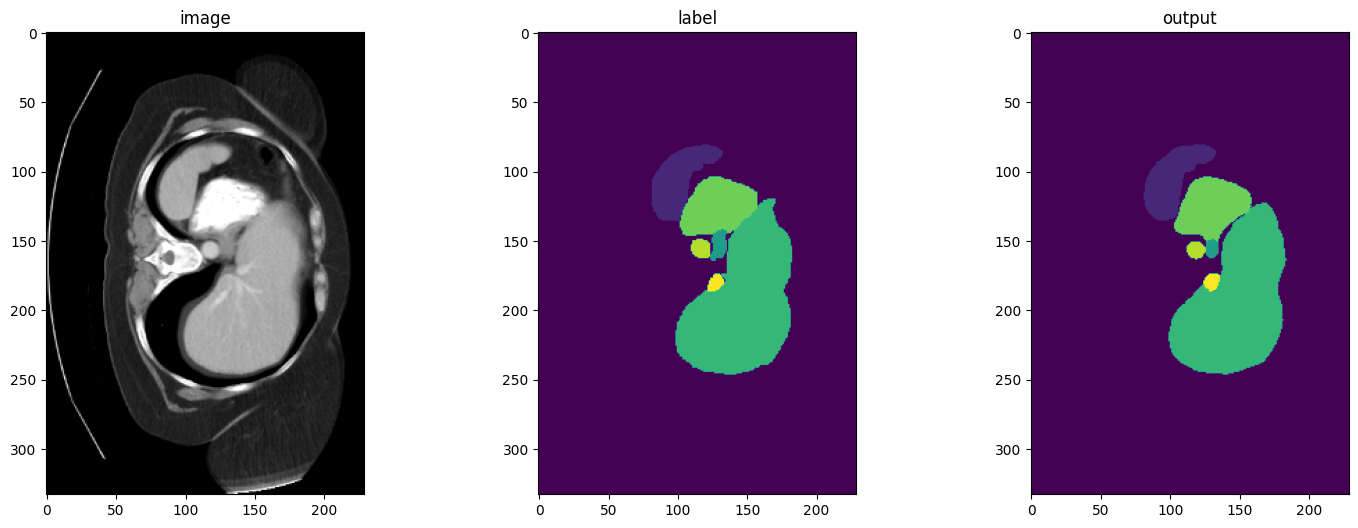

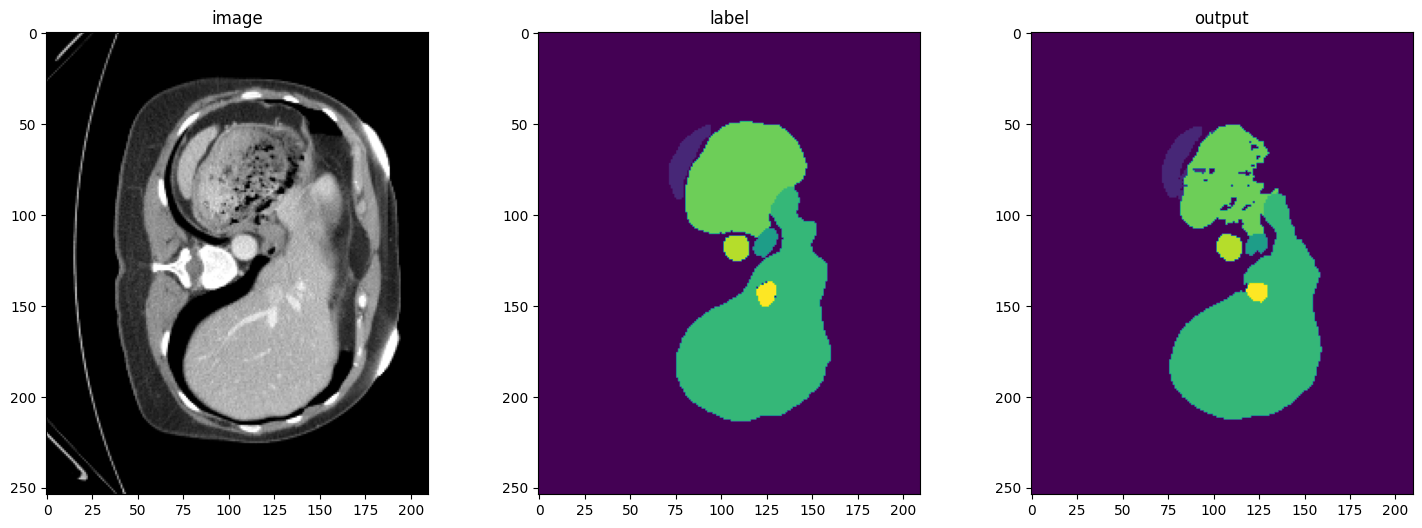

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
for case_num in range(4,6):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.show()